# Codeforces Problem Rating Predictor (Machine Learning Project)

This notebook outlines the steps for building a regression model to predict the difficulty rating of a Codeforces competitive programming problem based on its features, such as algorithmic tags, problem index, and number of successful submissions.

---

## I. Data Acquisition and Preparation

This section handles connecting to the Codeforces API, fetching the problems data, merging problem details with statistics, and saving the raw datasets.

### Cell 1: Import Necessary Libraries

We import the fundamental libraries required for the project, including utilities for API calls, data handling, and the core ML components used throughout the notebook.

In [1]:
import requests
import pandas as pd
import numpy as np
import os
import re 
from sklearn.preprocessing import MultiLabelBinarizer # For one-hot encoding tags

### Cell 2: Create Data Storage Folder

A directory named `data` is created to store the fetched raw files and processed CSVs. `exist_ok=True` prevents errors if the folder already exists.

In [2]:
os.makedirs("data", exist_ok=True)

### Cell 3: Fetch Data from Codeforces API

This cell calls the Codeforces `problemset.problems` API endpoint. It fetches two main lists: `problems` (containing ratings and tags) and `problemStatistics` (containing solved counts). A check ensures the API request was successful.

In [3]:
url = "https://codeforces.com/api/problemset.problems"
resp = requests.get(url)
data = resp.json()

if data['status'] != 'OK':
    raise Exception("API request failed")

problems = data['result']['problems']
stats = data['result']['problemStatistics']


### Cells 4 & 5: Convert to DataFrame and Merge

Lists are converted to pandas DataFrames (`df_problems`, `df_stats`) and merged into a single master DataFrame (`df`) based on the unique problem identifiers: **`contestId`** and **`index`**.

In [4]:
df_problems = pd.DataFrame(problems)
df_stats = pd.DataFrame(stats)


In [5]:
df = pd.merge(df_problems, df_stats, on=['contestId', 'index'])

### Cell 6: Initial Data Inspection

Viewing the head confirms the successful merge. We can see that many problems lack a `rating` (NaN) and the `tags` column is stored as a list of strings.

In [6]:
df.head(20)

,contestId,index,name,type,tags,rating,points,solvedCount
0,2169,F,Subsequence Problem,PROGRAMMING,"[combinatorics, dp, fft, math]",NaN,NaN,123
1,2169,E,Points Selection,PROGRAMMING,"[brute force, dp, geometry, greedy]",NaN,NaN,336
2,2169,D2,Removal of a Sequence (Hard Version),PROGRAMMING,"[binary search, constructive algorithms, divid...",NaN,NaN,1048
3,2169,D1,Removal of a Sequence (Easy Version),PROGRAMMING,"[binary search, bitmasks, geometry, implementa...",NaN,NaN,4397
4,2169,C,Range Operation,PROGRAMMING,"[math, two pointers]",NaN,NaN,6871
5,2169,B,Drifting Away,PROGRAMMING,"[greedy, implementation]",NaN,NaN,9668
6,2169,A,Alice and Bob,PROGRAMMING,[greedy],NaN,NaN,11800
7,2168,C,Intercepting Butterflies,PROGRAMMING,"[bitmasks, constructive algorithms, graphs, in...",NaN,NaN,679
8,2168,B,Locate,PROGRAMMING,"[binary search, combinatorics, constructive al...",NaN,NaN,1271
9,2168,A2,Encode and Decode (Hard Version),PROGRAMMING,"[bitmasks, interactive, math]",NaN,NaN,2677


### Cell 7: Save Full Dataset

The complete dataset, including both rated and unrated problems, is saved to CSV for archival and easy reloading.

In [7]:
df.to_csv("data/codeforces_problems_full.csv", index=False)
print("Saved full dataset to data/codeforces_problems_full.csv")

Saved full dataset to data/codeforces_problems_full.csv


### Cell 8: Filter and Save Rated Problems (Training Data)

Problems with missing `rating` values are dropped. The resulting `df_rated` is the **training dataset** for the model, as it contains our target variable.

In [8]:
df_rated = df.dropna(subset=['rating'])
df_rated.to_csv("data/codeforces_problems_rated.csv", index=False)
print("Saved rated problems to data/codeforces_problems_rated.csv")

Saved rated problems to data/codeforces_problems_rated.csv


### Cell 9: Rated Data Head Check

We check the head of `df_rated` to ensure all rows now contain a non-NaN value in the `rating` column.

In [9]:
df_rated.head(5)

,contestId,index,name,type,tags,rating,points,solvedCount
11,2167,G,Mukhammadali and the Smooth Array,PROGRAMMING,"[data structures, dp]",1600.0,NaN,7929
12,2167,F,"Tree, TREE!!!",PROGRAMMING,"[dfs and similar, dp, math, trees]",1600.0,NaN,4676
13,2167,E,khba Loves to Sleep!,PROGRAMMING,"[binary search, data structures, geometry, gre...",1600.0,NaN,6564
14,2167,D,Yet Another Array Problem,PROGRAMMING,"[brute force, implementation, math, number the...",1000.0,NaN,22587
15,2167,C,Isamatdin and His Magic Wand!,PROGRAMMING,"[constructive algorithms, greedy, implementati...",800.0,NaN,28493


### Cell 10: Filter and Save Unrated Problems

Problems with missing `rating` are isolated into `df_unrated`. This dataset is reserved for making final predictions.

In [10]:
df_unrated = df[df['rating'].isna()]
df_unrated.to_csv("data/codeforces_problems_unrated.csv", index=False)
print("Saved unrated problems to data/codeforces_problems_unrated.csv")


Saved unrated problems to data/codeforces_problems_unrated.csv


### Cell 9: Unrated Data Head Check

We check the head of `df_unrated` to ensure all rows now contain a NaN value in the `rating` column.

In [11]:
df_unrated.head(5)

,contestId,index,name,type,tags,rating,points,solvedCount
0,2169,F,Subsequence Problem,PROGRAMMING,"[combinatorics, dp, fft, math]",NaN,NaN,123
1,2169,E,Points Selection,PROGRAMMING,"[brute force, dp, geometry, greedy]",NaN,NaN,336
2,2169,D2,Removal of a Sequence (Hard Version),PROGRAMMING,"[binary search, constructive algorithms, divid...",NaN,NaN,1048
3,2169,D1,Removal of a Sequence (Easy Version),PROGRAMMING,"[binary search, bitmasks, geometry, implementa...",NaN,NaN,4397
4,2169,C,Range Operation,PROGRAMMING,"[math, two pointers]",NaN,NaN,6871


### Cell 12 & 13: Unrated and Full Data Checks

Final confirmation that `df_unrated` only contains problems with `NaN` rating, and a check on the original `df`.

In [12]:
df_unrated.head()

,contestId,index,name,type,tags,rating,points,solvedCount
0,2169,F,Subsequence Problem,PROGRAMMING,"[combinatorics, dp, fft, math]",NaN,NaN,123
1,2169,E,Points Selection,PROGRAMMING,"[brute force, dp, geometry, greedy]",NaN,NaN,336
2,2169,D2,Removal of a Sequence (Hard Version),PROGRAMMING,"[binary search, constructive algorithms, divid...",NaN,NaN,1048
3,2169,D1,Removal of a Sequence (Easy Version),PROGRAMMING,"[binary search, bitmasks, geometry, implementa...",NaN,NaN,4397
4,2169,C,Range Operation,PROGRAMMING,"[math, two pointers]",NaN,NaN,6871


In [13]:
df.head()

,contestId,index,name,type,tags,rating,points,solvedCount
0,2169,F,Subsequence Problem,PROGRAMMING,"[combinatorics, dp, fft, math]",NaN,NaN,123
1,2169,E,Points Selection,PROGRAMMING,"[brute force, dp, geometry, greedy]",NaN,NaN,336
2,2169,D2,Removal of a Sequence (Hard Version),PROGRAMMING,"[binary search, constructive algorithms, divid...",NaN,NaN,1048
3,2169,D1,Removal of a Sequence (Easy Version),PROGRAMMING,"[binary search, bitmasks, geometry, implementa...",NaN,NaN,4397
4,2169,C,Range Operation,PROGRAMMING,"[math, two pointers]",NaN,NaN,6871


## II. Feature Engineering

This section loads the rated data and transforms categorical and text-based columns into a numeric format suitable for machine learning models.

### Cell 14: Load Rated Data for Processing 

We reload the `df_rated` to ensure we have a clean DataFrame before feature transformations begin. Note that the `tags` column may appear as a string representation of a list when loaded from CSV.

In [14]:
# ============================================================
# Step 1: Load rated dataset
# ============================================================
import pandas as pd

df_rated = pd.read_csv("data/codeforces_problems_rated.csv")
df_rated.head()


,contestId,index,name,type,tags,rating,points,solvedCount
0,2167,G,Mukhammadali and the Smooth Array,PROGRAMMING,"['data structures', 'dp']",1600.0,NaN,7929
1,2167,F,"Tree, TREE!!!",PROGRAMMING,"['dfs and similar', 'dp', 'math', 'trees']",1600.0,NaN,4676
2,2167,E,khba Loves to Sleep!,PROGRAMMING,"['binary search', 'data structures', 'geometry...",1600.0,NaN,6564
3,2167,D,Yet Another Array Problem,PROGRAMMING,"['brute force', 'implementation', 'math', 'num...",1000.0,NaN,22587
4,2167,C,Isamatdin and His Magic Wand!,PROGRAMMING,"['constructive algorithms', 'greedy', 'impleme...",800.0,NaN,28493


### Cell 15: Transform Features (Tags & Index) 🛠️

This is the core feature engineering step:

1.  **Tags Parsing (Multi-Label):** A robust function (`parse_tags_string`) is defined and applied to convert the string list representations of tags into actual Python lists, which is necessary for multi-label processing.
2.  **One-Hot Encoding:** The **`MultiLabelBinarizer`** converts the tag lists into binary feature columns, where each unique tag becomes a feature (0/1).
3.  **Index Conversion:** The single-letter problem `index` (e.g., 'A', 'B', 'C') is converted into a numeric rank **`index_num`** (1, 2, 3...) to capture the difficulty curve within a contest.
4.  The original `tags` and intermediate `tags_list` columns are dropped.

In [15]:
# ============================================================
# Step 2: Feature Engineering
# - One-hot encode tags
# - Convert index (A, B, C, ...) to numeric
# ============================================================

# 1. Prepare Tags for MultiLabelBinarizer
def parse_tags_string(tags_str):
    """Parses a tags string '[tag1, tag2]' into a list ['tag1', 'tag2']."""
    if not isinstance(tags_str, str):
        return []

    # Remove surrounding brackets and split by comma + optional space
    content = tags_str.strip().strip('[]')
    if not content:
        return []

    # Split by comma and clean up each tag
    tags_list = [tag.strip() for tag in re.split(r',\s*', content) if tag.strip()]
    return tags_list

# Apply the parsing function to create a new 'tags_list' column
df_rated['tags_list'] = df_rated['tags'].apply(parse_tags_string)

# 2. One-hot encode tags using MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Use the 'tags_list' column for transformation
tags_encoded = mlb.fit_transform(df_rated['tags_list'])
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_, index=df_rated.index)

# Add encoded tags to the main dataframe
df_rated = pd.concat([df_rated, tags_df], axis=1)

# Drop the original 'tags' and intermediate 'tags_list' columns
df_rated = df_rated.drop(columns=['tags', 'tags_list'], errors='ignore')

# 3. Convert problem index to numeric: A=1, B=2, ...
df_rated['index_num'] = df_rated['index'].astype(str).str[0].str.upper().apply(lambda x: ord(x) - 64)


### Cell 16: Check Unique Tag Features

Displaying `mlb.classes_` confirms all unique tags extracted from the dataset are now the column headers for the one-hot encoded features.

In [16]:
print(mlb.classes_)

["'*special'" "'2-sat'" "'binary search'" "'bitmasks'" "'brute force'"
 "'chinese remainder theorem'" "'combinatorics'"
 "'constructive algorithms'" "'data structures'" "'dfs and similar'"
 "'divide and conquer'" "'dp'" "'dsu'" "'expression parsing'" "'fft'"
 "'flows'" "'games'" "'geometry'" "'graph matchings'" "'graphs'"
 "'greedy'" "'hashing'" "'implementation'" "'interactive'" "'math'"
 "'matrices'" "'meet-in-the-middle'" "'number theory'" "'probabilities'"
 "'schedules'" "'shortest paths'" "'sortings'"
 "'string suffix structures'" "'strings'" "'ternary search'" "'trees'"
 "'two pointers'"]


### Cell 17: Check First Row's Final Feature Vector

Inspects the first row of the processed data to verify that `index_num` has been correctly computed and the tag columns contain `1` for present tags and `0` for absent tags.

In [17]:
df_rated.head().iloc[0]

contestId                                                   2167
index                                                          G
name                           Mukhammadali and the Smooth Array
type                                                 PROGRAMMING
rating                                                    1600.0
points                                                       NaN
solvedCount                                                 7929
'*special'                                                     0
'2-sat'                                                        0
'binary search'                                                0
'bitmasks'                                                     0
'brute force'                                                  0
'chinese remainder theorem'                                    0
'combinatorics'                                                0
'constructive algorithms'                                      0
'data structures'        

## III. Model Training and Evaluation

This section prepares the final feature matrix $\mathbf{X}$ and target vector $\mathbf{y}$, splits the data, and trains several regression models to find the best predictor for the problem rating.

### Cell 18 & 19: Prepare Features (X) and Target (y)

1.  The `rating` column is isolated as the prediction target ($\mathbf{y}$).
2.  Non-numeric, non-feature columns (`index`, `name`, `type`) are dropped to create the feature matrix $\mathbf{X}$.
3.  The head of the final feature matrix $\mathbf{X}$ is displayed.

In [18]:
# ============================================================
# Step 3: Prepare features and target
# ============================================================

# Drop columns not used for ML
X = df_rated.drop(columns=['index','name','rating','type'])
y = df_rated['rating']


In [19]:
X.head(5)

,contestId,points,solvedCount,'*special','2-sat','binary search','bitmasks','brute force','chinese remainder theorem','combinatorics',...,'probabilities','schedules','shortest paths','sortings','string suffix structures','strings','ternary search','trees','two pointers',index_num
0,2167,NaN,7929,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,2167,NaN,4676,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,6
2,2167,NaN,6564,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,2167,NaN,22587,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4
4,2167,NaN,28493,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3


### Cell 20: Split Dataset (Train / CV / Test)

The data is split into three subsets using two applications of `train_test_split` with `random_state=42` for reproducibility:

1.  **Train (60%):** Used for fitting models.
2.  **Cross-Validation (CV) (20%):** Used for hyperparameter tuning and model selection.
3.  **Test (20%):** Used for final, unbiased evaluation.

Any remaining NaN values (primarily in `points`) are imputed with `0` in all splits.

In [20]:
# ============================================================
# Step 4: Split dataset into train / cross-validation / test
# ============================================================

from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

# Step 4a: Split train+cv vs test (80% train+cv, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Step 4b: Split train vs cross-validation (75% train, 25% cv of temp → 60% train, 20% cv)
X_train, X_cv, y_train, y_cv = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE
)

# Replace NaNs with 0 in all splits (mostly affects 'points')
X_train = X_train.fillna(0)
X_cv = X_cv.fillna(0)
X_test = X_test.fillna(0)


# Check sizes
print("Train set:", X_train.shape)
print("Cross-validation set:", X_cv.shape)
print("Test set:", X_test.shape)


Train set: (6303, 41)
Cross-validation set: (2102, 41)
Test set: (2102, 41)


### Cells 25-27: Inspect Data Splits

Verify the heads of the split feature datasets ($X_{\text{train}}, X_{\text{cv}}, X_{\text{test}}$) to confirm they align with the expected feature set.

In [21]:
X_train.head()

,contestId,points,solvedCount,'*special','2-sat','binary search','bitmasks','brute force','chinese remainder theorem','combinatorics',...,'probabilities','schedules','shortest paths','sortings','string suffix structures','strings','ternary search','trees','two pointers',index_num
1006,2001,1500.0,12301,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,3
8582,455,1500.0,6204,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,3
3472,1571,0.0,64,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
2601,1735,1250.0,10686,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3
10334,37,1000.0,1029,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [22]:
X_cv.head()

,contestId,points,solvedCount,'*special','2-sat','binary search','bitmasks','brute force','chinese remainder theorem','combinatorics',...,'probabilities','schedules','shortest paths','sortings','string suffix structures','strings','ternary search','trees','two pointers',index_num
8243,540,1500.0,7959,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1198,1974,0.0,10351,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
9178,294,500.0,26379,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10184,62,2000.0,404,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
5988,1057,1000.0,1914,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2


In [23]:
X_test.head()

,contestId,points,solvedCount,'*special','2-sat','binary search','bitmasks','brute force','chinese remainder theorem','combinatorics',...,'probabilities','schedules','shortest paths','sortings','string suffix structures','strings','ternary search','trees','two pointers',index_num
8985,343,500.0,9752,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
565,2066,2000.0,356,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
5173,1220,1000.0,12011,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3884,1491,1000.0,8277,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3
7823,638,2000.0,746,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4


### Cell 28: Model Comparison and Selection

This crucial cell runs the machine learning pipeline:

1.  **Utilities:** Helper functions like `round_to_nearest_100` are defined to handle Codeforces' 100-point rating steps.
2.  **Training & Tuning:** Multiple models (Linear, Ridge, Polynomial, Decision Tree, Random Forest, and XGBoost) are trained and tuned using **`GridSearchCV`** on the **training set**.
3.  **Cross-Validation Evaluation:** Models are evaluated on the **CV set**. The best model is selected based on the lowest **RMSE on rounded predictions**.
4.  **Final Test Evaluation:** The best model (**XGBoostRegressor**) is retrained on the combined Train+CV set and evaluated on the reserved **Test Set** to get the final, unbiased performance metrics.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import joblib

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    from xgboost import XGBRegressor
    XGB_PRESENT = True
except Exception:
    XGB_PRESENT = False

Path("models").mkdir(exist_ok=True)

RANDOM_STATE = 42

# ---------------------------
# Utilities
# ---------------------------
def round_to_nearest_100(preds):
    a = np.array(preds)
    return ((a + 50) // 100 * 100).astype(int)

def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

def evaluate_continuous_and_rounded(y_true, y_pred):
    y_true_arr = np.array(y_true)
    raw_rmse = rmse(y_true_arr, y_pred)
    pred_rounded = round_to_nearest_100(y_pred)
    rounded_rmse = rmse(y_true_arr, pred_rounded)
    rounded_rmse_hundreds = rounded_rmse / 100.0
    mae_steps = np.mean(np.abs(pred_rounded - y_true_arr) / 100.0)
    exact_match = np.mean(pred_rounded == y_true_arr)
    within_one_step = np.mean(np.abs(pred_rounded - y_true_arr) <= 100)

    return {
        "rmse_raw": float(raw_rmse),
        "rmse_rounded": float(rounded_rmse),
        "rmse_hundreds": float(rounded_rmse_hundreds),
        "mae_steps": float(mae_steps),
        "exact_match": float(exact_match),
        "within_±1_step": float(within_one_step)
    }

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# ---------------------------
# True K-Fold CV
# ---------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models_info = []

def save_trained_model(name, estimator):
    """Fits the estimator fully on X_train then saves it."""
    est = estimator
    if name.startswith("Polynomial"):
        est.fit(X_train[numeric_cols].fillna(0), y_train)
    else:
        est.fit(X_train.fillna(0), y_train)
    joblib.dump(est, f"models/{name}_trained.joblib")
    print(f"Saved: models/{name}_trained.joblib")


print("\nRunning 5-Fold CV and saving FULLY TRAINED models...\n")

# ---------------------------
# 1) Linear Regression
# ---------------------------
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])
pred_cv = cross_val_predict(lr, X_train.fillna(0), y_train, cv=kf, n_jobs=-1)
metrics = evaluate_continuous_and_rounded(y_train, pred_cv)

save_trained_model("LinearRegression", lr)

models_info.append({
    "name": "LinearRegression",
    "estimator": lr,
    **metrics
})

# ---------------------------
# 2) Ridge Regression
# ---------------------------
ridge_pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])
ridge_grid = {"ridge__alpha": [0.1, 1.0, 10.0, 50.0]}

ridge_search = GridSearchCV(
    ridge_pipe, ridge_grid, cv=3, 
    scoring="neg_mean_squared_error", n_jobs=-1
)

pred_cv = cross_val_predict(ridge_search, X_train.fillna(0), y_train, cv=kf, n_jobs=-1)
metrics = evaluate_continuous_and_rounded(y_train, pred_cv)

save_trained_model("Ridge", ridge_search)

models_info.append({
    "name": "Ridge",
    "estimator": ridge_search,
    **metrics
})

# ---------------------------
# 3 & 4) Polynomial Deg 2 and Deg 3
# ---------------------------
for deg in (2, 3):
    poly_pipe = Pipeline([
        ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ])

    pred_cv = cross_val_predict(
        poly_pipe, X_train[numeric_cols].fillna(0), y_train,
        cv=kf, n_jobs=-1
    )

    metrics = evaluate_continuous_and_rounded(y_train, pred_cv)

    name = f"Polynomial_deg{deg}"
    save_trained_model(name, poly_pipe)

    models_info.append({
        "name": name,
        "estimator": poly_pipe,
        "used_cols": numeric_cols,
        **metrics
    })

# ---------------------------
# 5) Decision Tree
# ---------------------------
dt_params = {"max_depth": [5, 10, 20, None], "min_samples_leaf": [1, 5]}

dt_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    dt_params,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

pred_cv = cross_val_predict(dt_search, X_train.fillna(0), y_train, cv=kf, n_jobs=-1)
metrics = evaluate_continuous_and_rounded(y_train, pred_cv)

save_trained_model("DecisionTreeRegressor", dt_search)

models_info.append({
    "name": "DecisionTreeRegressor",
    "estimator": dt_search,
    **metrics
})

# ---------------------------
# 6) RandomForest
# ---------------------------
rf_params = {"n_estimators": [50, 100],
             "max_depth": [10, 20, None],
             "min_samples_leaf": [1, 5]}

rf_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_params,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

pred_cv = cross_val_predict(rf_search, X_train.fillna(0), y_train, cv=kf, n_jobs=-1)
metrics = evaluate_continuous_and_rounded(y_train, pred_cv)

save_trained_model("RandomForestRegressor", rf_search)

models_info.append({
    "name": "RandomForestRegressor",
    "estimator": rf_search,
    **metrics
})

# ---------------------------
# 7) XGBoost (optional)
# ---------------------------
if XGB_PRESENT:
    xgb_params = {"n_estimators": [50, 100],
                  "max_depth": [3, 6],
                  "learning_rate": [0.05, 0.1]}

    xgb_search = GridSearchCV(
        XGBRegressor(objective="reg:squarederror",
                     random_state=42, n_jobs=-1),
        xgb_params,
        cv=3,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )

    pred_cv = cross_val_predict(
        xgb_search, X_train.fillna(0), y_train,
        cv=kf, n_jobs=-1
    )
    metrics = evaluate_continuous_and_rounded(y_train, pred_cv)

    save_trained_model("XGBoostRegressor", xgb_search)

    models_info.append({
        "name": "XGBoostRegressor",
        "estimator": xgb_search,
        **metrics
    })
    # --------------------------
# Summary table (sorted by CV RMSE)
# --------------------------
summary = []
for info in models_info:
    summary.append({
        "model": info["name"],
        "rmse_raw": info["rmse_raw"],
        "rmse_rounded": info["rmse_rounded"],
        "rmse_hundreds": info["rmse_hundreds"],
        "mae_steps": info["mae_steps"],
        "exact_match": info["exact_match"],
        "within_±1_step": info["within_±1_step"]
    })

summary_df = pd.DataFrame(summary).sort_values("rmse_rounded").reset_index(drop=True)
display(summary_df)

# --------------------------
# Select best model according to CV RMSE
# --------------------------
best_model_row = summary_df.iloc[0]
best_name = best_model_row["model"]
print(f"Selected best model: {best_name}")

# Get the estimator object
best_est = None
for info in models_info:
    if info["name"] == best_name:
        best_est = info["estimator"]
        break

# Retrain best on train+cv
X_traincv = pd.concat([X_train, X_cv], axis=0)
y_traincv = pd.concat([y_train, y_cv], axis=0)

if best_name.startswith("Polynomial"):
    X_traincv_in = X_traincv[numeric_cols].fillna(0)
else:
    X_traincv_in = X_traincv.fillna(0)

best_est.fit(X_traincv_in, y_traincv)
print("Best estimator retrained.")




Running 5-Fold CV and saving FULLY TRAINED models...

Saved: models/LinearRegression_trained.joblib
Saved: models/Ridge_trained.joblib
Saved: models/Polynomial_deg2_trained.joblib
Saved: models/Polynomial_deg3_trained.joblib
Saved: models/DecisionTreeRegressor_trained.joblib
Saved: models/RandomForestRegressor_trained.joblib


,model,rmse_raw,rmse_rounded,rmse_hundreds,mae_steps,exact_match,within_±1_step
0,RandomForestRegressor,2.063755e+02,2.082009e+02,2.082009e+00,1.473901e+00,0.257020,0.625258
1,DecisionTreeRegressor,2.356337e+02,2.371662e+02,2.371662e+00,1.706965e+00,0.224972,0.562748
2,LinearRegression,4.250932e+02,4.260366e+02,4.260366e+00,3.131525e+00,0.098207,0.298112
3,Ridge,4.250069e+02,4.261651e+02,4.261651e+00,3.134222e+00,0.098049,0.298747
4,Polynomial_deg2,4.877645e+15,3.084099e+08,3.084099e+06,4.429238e+05,0.125813,0.361891
5,Polynomial_deg3,1.232994e+16,1.202984e+09,1.202984e+07,6.739060e+06,0.093606,0.262573


Selected best model: RandomForestRegressor
Best estimator retrained.


## IV. Prediction on Unrated Problem

This section demonstrates how to use the final selected model to predict the rating of a specific, unrated Codeforces problem.

In [25]:
# Predict rating for an unrated problem using all models + best model
import requests
import re
import random
import numpy as np
import pandas as pd

# --------------------------
# Helpers
# --------------------------
def fetch_problem_from_api(contestId=None, index=None, url=None):
    """
    Return the problem dict from Codeforces API (problemset.problems result).
    Provide either contestId+index (ints/str) or a problem url (contest+index).
    If nothing provided, returns None.
    """
    api_url = "https://codeforces.com/api/problemset.problems"
    resp = requests.get(api_url)
    resp.raise_for_status()
    data = resp.json()
    if data.get("status") != "OK":
        raise RuntimeError("Codeforces API error")
    problems = data["result"]["problems"]

    if url:
        # try to extract contestId and index from common URL patterns
        m = re.search(r'/contest/(\d+)/problem/([A-Za-z0-9]+)', url)
        if not m:
            m = re.search(r'/problemset/problem/(\d+)/([A-Za-z0-9]+)', url)
        if m:
            contestId = int(m.group(1))
            index = m.group(2)

    if contestId is not None and index is not None:
        # find matching problem
        for p in problems:
            # contestId might be int or str in source
            if str(p.get("contestId")) == str(contestId) and str(p.get("index")).upper() == str(index).upper():
                return p
        raise ValueError(f"Problem {contestId}-{index} not found in API result.")
    return None

def sample_unrated_problem_from_csv(csv_path="data/codeforces_problems_unrated.csv"):
    df_unrated = pd.read_csv(csv_path)
    if df_unrated.empty:
        raise ValueError("No unrated problems in CSV")
    row = df_unrated.sample(1).iloc[0].to_dict()
    return row

def build_feature_vector(problem, X_columns, numeric_cols):
    """
    Build a single-row DataFrame aligned with training feature columns (X_columns).
    """
    # Start with zeros
    feat = {c: 0 for c in X_columns}

    # contestId
    if "contestId" in problem and not pd.isna(problem.get("contestId")):
        feat["contestId"] = int(problem.get("contestId"))
    # index -> index_num (A->1, B->2 ...)
    idx = problem.get("index", None)
    if isinstance(idx, str) and len(idx) > 0:
        try:
            feat["index_num"] = ord(idx[0].upper()) - 64
        except Exception:
            feat["index_num"] = 0
    # points (may be missing)
    points = problem.get("points", None)
    if points is not None and not pd.isna(points):
        try:
            feat["points"] = float(points)
        except Exception:
            feat["points"] = 0.0
    
    # tags: API gives list of tags
    tags = problem.get("tags", [])
    # Some CSV rows store tags as "tag1,tag2,..."
    if isinstance(tags, str):
        tags = [t.strip() for t in tags.split(",") if t.strip()]

    # For every tag column in X_columns, set 1 if tag present
    for tag in tags:
        # Handle cases where tags may be quoted (e.g. from CSV load) or unquoted
        tag_clean = tag.strip("' ")
        if tag_clean in feat:
            feat[tag_clean] = 1
        # Check for quoted version (as columns in X are quoted)
        tag_quoted = f"'{tag_clean}'"
        if tag_quoted in feat:
            feat[tag_quoted] = 1

    # Ensure dtypes & final DataFrame
    row_df = pd.DataFrame([feat], columns=X_columns)
    row_df = row_df.fillna(0)
    return row_df

def predict_with_models_on_row(row_df, models_info, numeric_cols):
    """
    For each model in models_info, call .predict() appropriately and return results list.
    """
    out = []
    for info in models_info:
        name = info["name"]
        est = info["estimator"]
        if name.startswith("Polynomial"):
            # polynomial models were trained on numeric subset only
            X_in = row_df[numeric_cols].fillna(0)
        else:
            X_in = row_df.fillna(0)
        pred_raw = est.predict(X_in)[0]
        pred_rounded = int(((pred_raw + 50) // 100) * 100)
        out.append({
            "model": name,
            "pred_raw": float(pred_raw),
            "pred_rounded": pred_rounded
        })
    return out

# --------------------------
# 1) Choose a problem:
# --------------------------
# Example problem to predict (currently unrated on the latest API dump):
contestId_input = 2156
index_input = "A"
problem_url = "https://codeforces.com/contest/2156/problem/A"

# fetch problem info
if contestId_input or index_input or problem_url:
    try:
        prob = fetch_problem_from_api(contestId=contestId_input, index=index_input, url=problem_url)
        print("Fetched problem from Codeforces API:")
        print(f"  contestId={prob.get('contestId')}, index={prob.get('index')}, name={prob.get('name')}")
    except Exception as e:
        # Fallback to sampling unrated from CSV if API fails or problem isn't found in API dump.
        print("API fetch failed or problem not found. Sampling a random unrated problem from CSV.")
        sampled = sample_unrated_problem_from_csv("data/codeforces_problems_unrated.csv")
        prob = {
            "contestId": sampled.get("contestId"),
            "index": sampled.get("index"),
            "name": sampled.get("name"),
            "points": sampled.get("points", None),
            "tags": sampled.get("tags")
        }
        if isinstance(prob["tags"], str):
            prob["tags"] = [t.strip() for t in prob["tags"].split(",") if t.strip()]
        print("Sampled unrated problem:")
        print(f"  contestId={prob.get('contestId')}, index={prob.get('index')}, name={prob.get('name')}")
else:
    # sample a random unrated problem from CSV you saved earlier
    print("No contestId/index/url provided — sampling a random unrated problem from data/codeforces_problems_unrated.csv")
    sampled = sample_unrated_problem_from_csv("data/codeforces_problems_unrated.csv")
    prob = {
        "contestId": sampled.get("contestId"),
        "index": sampled.get("index"),
        "name": sampled.get("name"),
        "points": sampled.get("points", None),
        "tags": sampled.get("tags")
    }
    if isinstance(prob["tags"], str):
        prob["tags"] = [t.strip() for t in prob["tags"].split(",") if t.strip()]
    print("Sampled unrated problem:")
    print(f"  contestId={prob.get('contestId')}, index={prob.get('index')}, name={prob.get('name')}")

# --------------------------
# 2) Build feature vector matching X_train columns
# --------------------------
X_columns = X_train.columns.tolist()
row_feat = build_feature_vector(prob, X_columns, numeric_cols)
print("\nFeature vector prepared (showing non-zero entries):")
display(row_feat.loc[:, (row_feat != 0).any(axis=0)])

# --------------------------
# 3) Predict with every model and display results
# --------------------------
preds = predict_with_models_on_row(row_feat, models_info, numeric_cols)
preds_df = pd.DataFrame(preds).sort_values("pred_rounded").reset_index(drop=True)
print("\nPredictions from all models (rounded to nearest 100):")
display(preds_df)

# --------------------------
# 4) Best model prediction (best_est was retrained on train+cv in the previous cell)
# --------------------------
# best_est is the retrained best estimator
try:
    # detect polynomial best case
    best_name_local = best_model_row["model"]
    if best_name_local.startswith("Polynomial"):
        X_in = row_feat[numeric_cols].fillna(0)
    else:
        X_in = row_feat.fillna(0)
    best_raw = best_est.predict(X_in)[0]
    best_rounded = int(((best_raw + 50) // 100) * 100)
    print(f"\nBest model ({best_name_local}) prediction:")
    print(f"  raw prediction  = {best_raw:.2f}")
    print(f"  rounded (±50 rule) = {best_rounded}")
except Exception as e:
    print("Could not compute best-model prediction — make sure previous cell ran and defined `best_est` and `best_model_row`.")
    raise

# --------------------------
# 5) Save the single-row feature vector and predictions for later inspection (optional)
# --------------------------
row_feat.to_csv("models/last_unrated_problem_features.csv", index=False)
preds_df.to_csv("models/last_unrated_problem_predictions.csv", index=False)
print("\nSaved feature vector to models/last_unrated_problem_features.csv")
print("Saved predictions to models/last_unrated_problem_predictions.csv")


Fetched problem from Codeforces API:
  contestId=2156, index=A, name=Pizza Time

Feature vector prepared (showing non-zero entries):


,contestId,points,'brute force','constructive algorithms','greedy',index_num
0,2156,500.0,1,1,1,1



Predictions from all models (rounded to nearest 100):


,model,pred_raw,pred_rounded
0,LinearRegression,1375.350021,1400
1,Ridge,1376.995281,1400
2,Polynomial_deg3,1536.230119,1500
3,Polynomial_deg2,1708.286915,1700
4,RandomForestRegressor,3401.000000,3400
5,DecisionTreeRegressor,3471.428571,3500



Best model (RandomForestRegressor) prediction:
  raw prediction  = 3401.00
  rounded (±50 rule) = 3400

Saved feature vector to models/last_unrated_problem_features.csv
Saved predictions to models/last_unrated_problem_predictions.csv


## # Rating Distribution

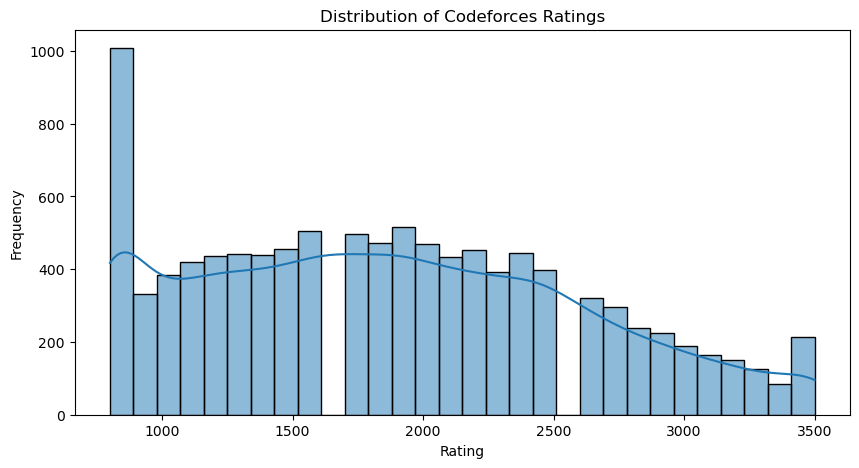

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['rating'], bins=30, kde=True)
plt.title('Distribution of Codeforces Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

## # Solved Count Distribution

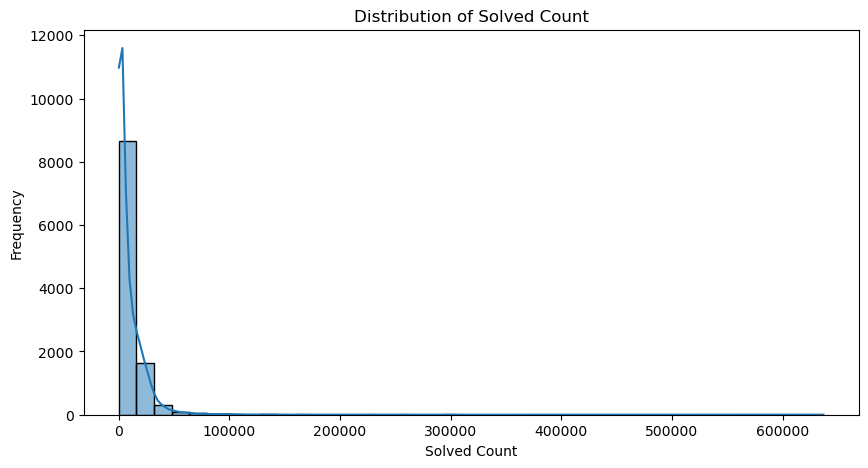

In [28]:
plt.figure(figsize=(10, 5))
sns.histplot(df['solvedCount'], bins=40, kde=True)
plt.title('Distribution of Solved Count')
plt.xlabel('Solved Count')
plt.ylabel('Frequency')
plt.show()

## # Scatter

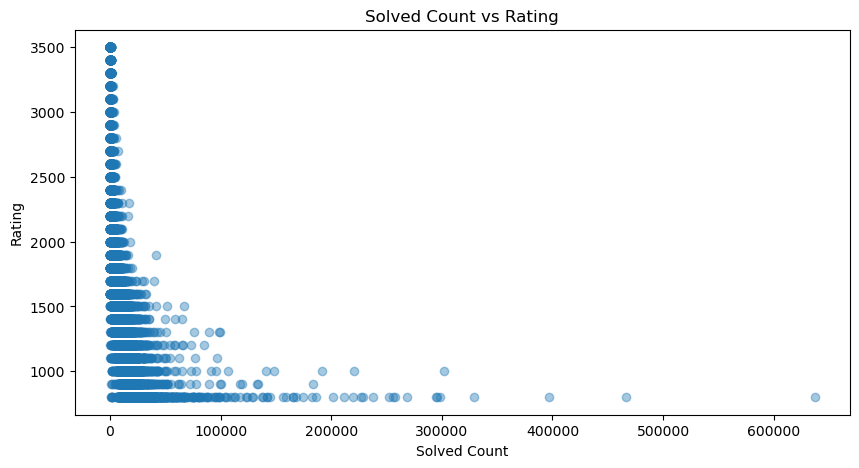

In [29]:
plt.figure(figsize=(10, 5))
plt.scatter(df['solvedCount'], df['rating'], alpha=0.4)
plt.xlabel('Solved Count')
plt.ylabel('Rating')
plt.title('Solved Count vs Rating')
plt.show()

## # Heatmap

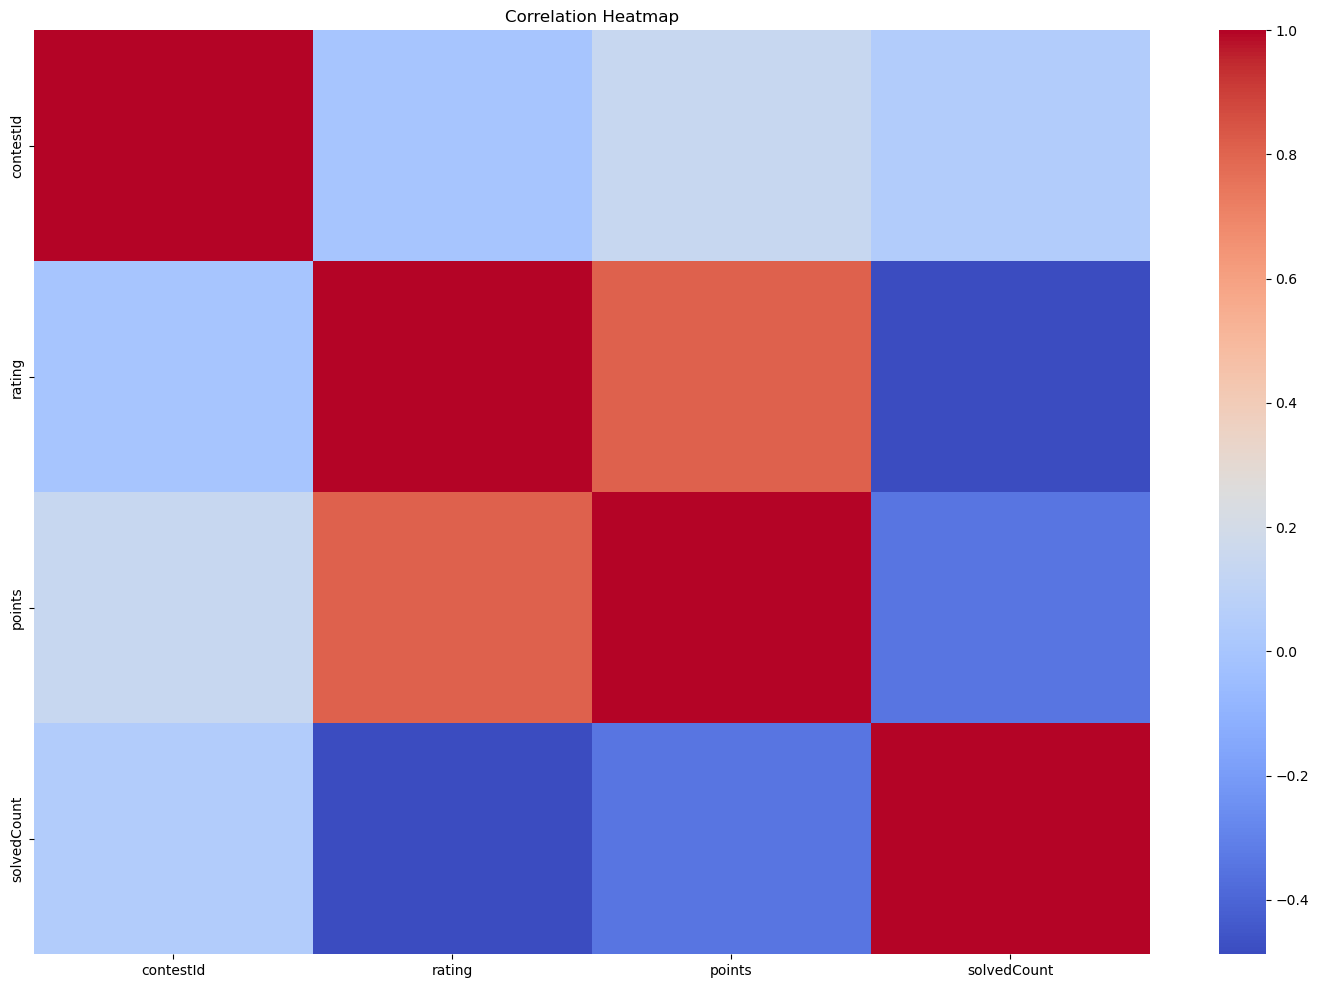

In [32]:
plt.figure(figsize=(18, 12))
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## # Pred vs Actual

In [31]:
y_pred=best_model.predict(X_test_scaled)
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted Rating')
plt.plot([0,4000],[0,4000],'r--')
plt.show()

NameError: name 'best_model' is not defined

## # Residuals

In [ ]:
residuals=y_test-y_pred
plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

## # Feature Importances

In [ ]:
if hasattr(best_model,'feature_importances_'):
    importances=best_model.feature_importances_
    indices=np.argsort(importances)[::-1]
    plt.figure(figsize=(12,8))
    plt.bar(range(20), importances[indices][:20])
    plt.xticks(range(20), X_train.columns[indices][:20], rotation=90)
    plt.title('Top 20 Feature Importances')
    plt.show()
else:
    print('No feature importances')